<a href="https://colab.research.google.com/github/bonnefco/P8/blob/main/P8_BERT_MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import ast
from scipy import stats
import tensorflow
from sklearn.model_selection import train_test_split

In [2]:
!pip install transformers
import transformers
from transformers import TFAutoModel
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
tensorflow.keras.backend.clear_session()

# Fonctions utiles

In [4]:
def plot_curves(history):

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

  return

# Nettoyage

## Chargement fichier source

In [5]:
df_effective_args = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/P8/dataset/train_light.csv',encoding="utf-8",header=(0))
df_effective_args

,discourse_text,discourse_type,discourse_effectiveness
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,"On my perspective, I think that the face is a ...",Position,Adequate
2,I think that the face is a natural landform be...,Claim,Adequate
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,People thought that the face was formed by ali...,Counterclaim,Adequate
...,...,...,...
36672,For many people they don't like only asking on...,Claim,Adequate
36673,also people have different views and opinions ...,Claim,Adequate
36674,Advice is something that can impact a persons ...,Position,Adequate
36675,someone can use everything that many people sa...,Evidence,Ineffective


## Encodage des labels

In [6]:
df_effective_args["discourse_effectiveness_number"] = df_effective_args["discourse_effectiveness"].replace({"Ineffective": 0, "Adequate": 1, "Effective": 2})

credits : https://www.kaggle.com/code/iamleonie/feedback-prize-eda-starter-for-beginners

Get the sep_token from the tokenizer and create the input sequences from discourse_type and discourse_text.

sep_token - A special token separating two different sentences in the same input (see https://huggingface.co/docs/transformers/main_classes/tokenizer)

## Feature Engineering

In [7]:
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer_BERT = transformers.AutoTokenizer.from_pretrained(MODEL_NAME, pad_token = '[PAD]', max_length=512, truncation = True)

In [8]:
sep = tokenizer_BERT.sep_token
df_effective_args['discourse_type_SEP_discourse_text'] = df_effective_args.discourse_type + sep + df_effective_args.discourse_text
df_effective_args.head(3)

,discourse_text,discourse_type,discourse_effectiveness,discourse_effectiveness_number,discourse_type_SEP_discourse_text
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin..."
1,"On my perspective, I think that the face is a ...",Position,Adequate,1,"Position[SEP]On my perspective, I think that t..."
2,I think that the face is a natural landform be...,Claim,Adequate,1,Claim[SEP]I think that the face is a natural l...


## Tokenization

In [9]:
df_effective_args['discourse_tokenized'] = df_effective_args['discourse_type_SEP_discourse_text'].apply(tokenizer_BERT.tokenize)

Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors


In [10]:
df_effective_args.head(3)

,discourse_text,discourse_type,discourse_effectiveness,discourse_effectiveness_number,discourse_type_SEP_discourse_text,discourse_tokenized
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin...","[lead, [SEP], hi, ,, i, ', m, isaac, ,, i, ', ..."
1,"On my perspective, I think that the face is a ...",Position,Adequate,1,"Position[SEP]On my perspective, I think that t...","[position, [SEP], on, my, perspective, ,, i, t..."
2,I think that the face is a natural landform be...,Claim,Adequate,1,Claim[SEP]I think that the face is a natural l...,"[claim, [SEP], i, think, that, the, face, is, ..."


## Longueur chaine de caractere

In [11]:
def counter_len_in_text(string):
  return len(string)

In [12]:
df_effective_args['Longueur_texte'] = df_effective_args['discourse_tokenized'].apply(counter_len_in_text)

In [13]:
df_effective_args.head(3)

,discourse_text,discourse_type,discourse_effectiveness,discourse_effectiveness_number,discourse_type_SEP_discourse_text,discourse_tokenized,Longueur_texte
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin...","[lead, [SEP], hi, ,, i, ', m, isaac, ,, i, ', ...",84
1,"On my perspective, I think that the face is a ...",Position,Adequate,1,"Position[SEP]On my perspective, I think that t...","[position, [SEP], on, my, perspective, ,, i, t...",52
2,I think that the face is a natural landform be...,Claim,Adequate,1,Claim[SEP]I think that the face is a natural l...,"[claim, [SEP], i, think, that, the, face, is, ...",26


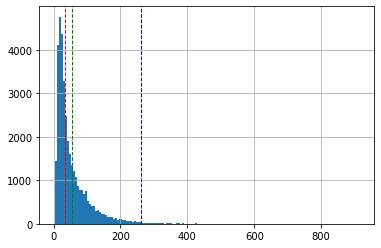

valeur du 99eme percentile = 261.0


In [14]:
plt.figure()
df_effective_args['Longueur_texte'].hist(bins=150)
plt.axvline(df_effective_args['Longueur_texte'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(df_effective_args['Longueur_texte'].median(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(df_effective_args['Longueur_texte'].quantile(.99), color='b', linestyle='dashed', linewidth=1)
plt.show()

print('valeur du 99eme percentile =', df_effective_args['Longueur_texte'].quantile(.99))

In [15]:
MAX_LEN = 270

# Encodage BERT

In [16]:
# sample_sequence = df_effective_args['discourse_type_SEP_discourse_text'].iloc[500]
# print(sample_sequence)


# token = tokenizer_BERT(sample_sequence, 
#                   max_length         = MAX_LEN, 
#                   truncation         = True, 
#                   padding            = 'max_length',
#                   add_special_tokens = True,
#                   return_tensors     = "np"
#                  )
    
# print('\ninput_ids:')
# print(token['input_ids'])
# print('\nattention_mask:')
# print(token['attention_mask'])
# print(token['attention_mask'].sum())
# print(len(tokenizer_BERT.tokenize(sample_sequence)))

In [17]:
def bert_encode(texts, tokenizer = tokenizer_BERT):

    token = tokenizer(texts, 
                      max_length         = MAX_LEN, 
                      truncation         = True, 
                      padding            = "max_length",
                      add_special_tokens = True,
                      return_tensors     = "tf")
        
    input_ids = token['input_ids']
    attention_mask = token['attention_mask']
    
    return input_ids[0], attention_mask[0]

Let's have a look at what the tokenizer does with one sample:

The function bert_encode() returns two arrays: input_ids andattention_mask

https://huggingface.co/docs/transformers/main_classes/tokenizer

*   input_ids — List of token ids to be fed to a model.

*    attention_mask — List of indices specifying which tokens should be attended to by the model (when return_attention_mask=True or if “attention_mask” is in self.model_input_names).

# Creation modele

## Hyper-paramètres

In [18]:
# Configuration
BATCH_SIZE = 8
DROPOUT = 0.1
LEARNING_RATE = 5e-5
MAX_LEN = MAX_LEN

In [19]:
X = df_effective_args['discourse_type_SEP_discourse_text']
y = df_effective_args['discourse_effectiveness_number']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = list(y_train)
y_valid= list(y_valid)

In [20]:
X_train = X_train.transform(bert_encode)
X_valid = X_valid.transform(bert_encode)
X_train_words_encoded, X_train_mask = zip(*X_train)
X_valid_words_encoded, X_valid_mask = zip(*X_valid)

Dataset Valid

In [21]:
valid_input_words_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_valid_words_encoded)))
            .batch(BATCH_SIZE)
)


valid_input_mask_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_valid_mask)))
            .batch(BATCH_SIZE)
)

valid_output_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((y_valid))
            .batch(BATCH_SIZE)
)

data_valid_words_mask = tensorflow.data.Dataset.zip((valid_input_words_dataset, valid_input_mask_dataset))
data_valid = tensorflow.data.Dataset.zip((data_valid_words_mask, valid_output_dataset))
print(data_valid.element_spec)

((TensorSpec(shape=(None, 270), dtype=tf.int32, name=None), TensorSpec(shape=(None, 270), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Dataset train

In [22]:
train_input_words_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_train_words_encoded)))
            .batch(BATCH_SIZE)
)


train_input_mask_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_train_mask)))
            .batch(BATCH_SIZE)
)

train_output_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((y_train))
            .batch(BATCH_SIZE)
)

data_train_words_mask = tensorflow.data.Dataset.zip((train_input_words_dataset, train_input_mask_dataset))
data_train = tensorflow.data.Dataset.zip((data_train_words_mask, train_output_dataset))

print(data_train.element_spec)

((TensorSpec(shape=(None, 270), dtype=tf.int32, name=None), TensorSpec(shape=(None, 270), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


## Entrainement

### Modele de base

In [ ]:
input_ids = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "input_ids")
attention_mask = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "attention_mask")

transformer_layer = (transformers.TFAutoModel.from_pretrained(MODEL_NAME))

sequence_output = transformer_layer([input_ids, attention_mask])['last_hidden_state']
clf_output = sequence_output[:, 0, :]
layer = tensorflow.keras.layers.Dense(128, activation="relu")(clf_output)
out = tensorflow.keras.layers.Dense(3, activation='softmax')(layer)

model = tensorflow.keras.Model(inputs = [input_ids, attention_mask], 
              outputs = out)

model.compile(tensorflow.keras.optimizers.Adam(learning_rate = LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
#model.summary()

Epoch 1/20
3668/3668 [==============================] - 616s 166ms/step - loss: 0.7700 - accuracy: 0.6530 - val_loss: 0.7545 - val_accuracy: 0.6801
Epoch 2/20
3668/3668 [==============================] - 609s 166ms/step - loss: 0.6365 - accuracy: 0.7172 - val_loss: 0.7452 - val_accuracy: 0.6644
Epoch 3/20
3668/3668 [==============================] - 609s 166ms/step - loss: 0.4673 - accuracy: 0.8022 - val_loss: 0.8131 - val_accuracy: 0.6456
Epoch 4/20
3668/3668 [==============================] - 608s 166ms/step - loss: 0.3329 - accuracy: 0.8676 - val_loss: 0.9984 - val_accuracy: 0.6291
Epoch 4: early stopping


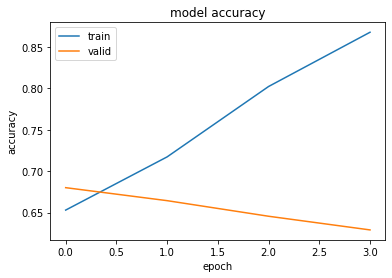

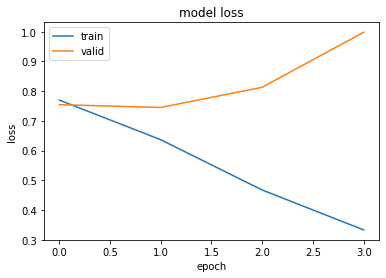

In [25]:
Stopping_condition = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.03,
    patience=3,
    #mode='max',
    verbose=1)

history = model.fit(
    data_train, 
    epochs=20,
    #validation_steps = validation_size // batch_size,
    validation_data=data_valid,
    #steps_per_epoch = train_size // batch_size,
    callbacks=[Stopping_condition]    
)

model.save('/content/drive/MyDrive/Colab_Notebooks/P8/models/bert_model_1.h5')

plot_curves(history)

### Ajout BatchNormalisation

In [32]:
input_ids = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "input_ids")
attention_mask = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "attention_mask")

transformer_layer = (transformers.TFAutoModel.from_pretrained(MODEL_NAME))

sequence_output = transformer_layer([input_ids, attention_mask])['last_hidden_state']
clf_output = sequence_output[:, 0, :]
layer = tensorflow.keras.layers.BatchNormalization()(clf_output)
layer = tensorflow.keras.layers.Dense(128, activation="relu")(layer)
out = tensorflow.keras.layers.Dense(3, activation='softmax')(layer)

model = tensorflow.keras.Model(inputs = [input_ids, attention_mask], 
              outputs = out)

model.compile(tensorflow.keras.optimizers.Adam(learning_rate = LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['classifier', 'pre_classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [33]:
Stopping_condition = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.03,
    patience=3,
    #mode='max',
    verbose=1)

history = model.fit(
    data_train, 
    epochs=20,
    #validation_steps = validation_size // batch_size,
    validation_data=data_valid,
    #steps_per_epoch = train_size // batch_size,
    callbacks=[Stopping_condition]    
)

model.save('/content/drive/MyDrive/Colab_Notebooks/P8/models/bert_model_2.h5')

Epoch 1/20
3668/3668 [==============================] - 617s 166ms/step - loss: 0.8751 - accuracy: 0.6019 - val_loss: 0.8082 - val_accuracy: 0.6329
Epoch 2/20
3668/3668 [==============================] - 610s 166ms/step - loss: 0.7564 - accuracy: 0.6593 - val_loss: 0.8749 - val_accuracy: 0.6554
Epoch 3/20
3668/3668 [==============================] - 609s 166ms/step - loss: 0.6466 - accuracy: 0.7118 - val_loss: 0.8602 - val_accuracy: 0.6378
Epoch 4/20
3668/3668 [==============================] - 607s 166ms/step - loss: 0.4899 - accuracy: 0.7944 - val_loss: 0.9814 - val_accuracy: 0.6261
Epoch 4: early stopping


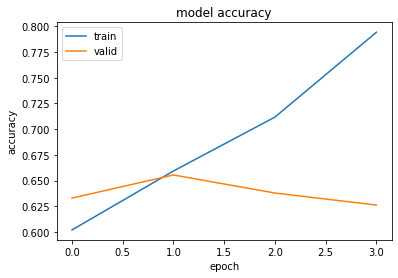

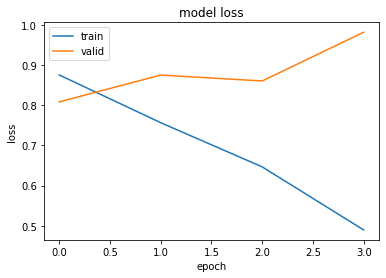

In [34]:
plot_curves(history)

### Multi Sample Drop Out

# https://towardsdatascience.com/multi-sample-dropout-in-keras-ea8b8a9bfd83
Multi sample dropout

In [25]:
def multi_sample_drop_out(layer_in, structure_dense_1, structure_dense_2, number_of_dropout):
  concat_dropout_layer = []
  for ratio in np.linspace(0.1,0.5, number_of_dropout):
    layer = tensorflow.keras.layers.Dropout(ratio)(layer_in)
    layer = structure_dense_1(layer)
    layer = tensorflow.keras.layers.BatchNormalization()(layer)
    layer = structure_dense_2(layer)
    concat_dropout_layer.append(layer)
  layer_out = tensorflow.keras.layers.Average()(concat_dropout_layer)

  return layer_out

In [26]:
input_ids = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "input_ids")
attention_mask = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "attention_mask")

transformer_layer = (transformers.TFAutoModel.from_pretrained(MODEL_NAME))

sequence_output = transformer_layer([input_ids, attention_mask])['last_hidden_state']
clf_output = sequence_output[:, 0, :]
out = multi_sample_drop_out(clf_output, tensorflow.keras.layers.Dense(128, activation="relu"), tensorflow.keras.layers.Dense(3, activation='softmax'), 4)
model = tensorflow.keras.Model(inputs = [input_ids, attention_mask], 
              outputs = out)

model.compile(tensorflow.keras.optimizers.Adam(learning_rate = LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['dropout_19', 'classifier', 'pre_classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [27]:
Stopping_condition = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.03,
    patience=3,
    #mode='max',
    verbose=1)

history = model.fit(
    data_train, 
    epochs=20,
    #validation_steps = validation_size // batch_size,
    validation_data=data_valid,
    #steps_per_epoch = train_size // batch_size,
    callbacks=[Stopping_condition]    
)

model.save('/content/drive/MyDrive/Colab_Notebooks/P8/models/bert_model_3.hdf5')

Epoch 1/20
3668/3668 [==============================] - 623s 168ms/step - loss: 0.8571 - accuracy: 0.6090 - val_loss: 0.7525 - val_accuracy: 0.6528
Epoch 2/20
3668/3668 [==============================] - 614s 167ms/step - loss: 0.7089 - accuracy: 0.6909 - val_loss: 0.7745 - val_accuracy: 0.6741
Epoch 3/20
3668/3668 [==============================] - 614s 167ms/step - loss: 0.5317 - accuracy: 0.7854 - val_loss: 0.9532 - val_accuracy: 0.6250
Epoch 4/20
3668/3668 [==============================] - 614s 167ms/step - loss: 0.3647 - accuracy: 0.8642 - val_loss: 1.1133 - val_accuracy: 0.6412
Epoch 4: early stopping


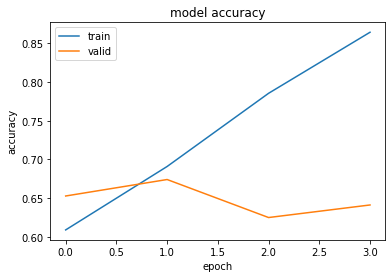

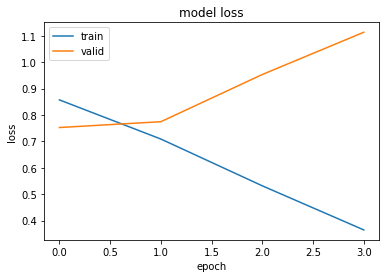

In [28]:
plot_curves(history)

## Pas de batch normalisation

In [29]:
def multi_sample_drop_out(layer_in, structure_dense_1, structure_dense_2, number_of_dropout):
  concat_dropout_layer = []
  for ratio in np.linspace(0.1,0.5, number_of_dropout):
    layer = tensorflow.keras.layers.Dropout(ratio)(layer_in)
    layer = structure_dense_1(layer)
    layer = structure_dense_2(layer)
    concat_dropout_layer.append(layer)
  layer_out = tensorflow.keras.layers.Average()(concat_dropout_layer)

  return layer_out

In [30]:
input_ids = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "input_ids")
attention_mask = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "attention_mask")

transformer_layer = (transformers.TFAutoModel.from_pretrained(MODEL_NAME))

sequence_output = transformer_layer([input_ids, attention_mask])['last_hidden_state']
clf_output = sequence_output[:, 0, :]
out = multi_sample_drop_out(clf_output, tensorflow.keras.layers.Dense(128, activation="relu"), tensorflow.keras.layers.Dense(3, activation='softmax'), 4)
model = tensorflow.keras.Model(inputs = [input_ids, attention_mask], 
              outputs = out)

model.compile(tensorflow.keras.optimizers.Adam(learning_rate = LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertModel: ['dropout_19', 'classifier', 'pre_classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [32]:
Stopping_condition = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.03,
    patience=1,
    #mode='max',
    verbose=1)

history = model.fit(
    data_train, 
    epochs=1,
    #validation_steps = validation_size // batch_size,
    validation_data=data_valid,
    #steps_per_epoch = train_size // batch_size,
    callbacks=[Stopping_condition]    
)

model.save('/content/drive/MyDrive/Colab_Notebooks/P8/models/bert_model_4.hdf5')

3668/3668 [==============================] - 614s 167ms/step - loss: 0.7614 - accuracy: 0.6603 - val_loss: 0.7420 - val_accuracy: 0.6797


In [ ]:
model.predict()